# 1) Importando Bibliotecas

In [ ]:
import pandas as pd
from random import random
from random import randint
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_decision_regions
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 2) Entendendo a Base de Dados

In [ ]:
url = 'https://raw.githubusercontent.com/SarahLMelo/AirplaneAnalysis/main/diabetes_prediction_dataset.csv'
bd = pd.read_csv(url)

Vamos ver a quantidade de dados (linhas) e de campos (colunas) presentes nela:

In [ ]:
bd.shape

(100000, 9)

Abaixo estão listados os nove campos do dataframe, juntamente com seus respectivos tipos.

In [ ]:
bd.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

Percebe-se que a maioria dos campos contém valores numéricos, com exceção de dois campos em particular, "gender" e "smoking_history" que possuem valores do tipo "object".

Para entender melhor quais valores são possíveis para cada campo, é necessário analisar mais detalhadamente os dados da base:

In [ ]:
bd

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


Ao examinar os 5 primeiros e os 5 últimos dados da base de dados, é possível notar que o campo "gender" parece ter os valores possíveis "Male" e "Female", enquanto os campos "hypertension" e "heart_disease" apresentam valores binários. No entanto, o campo "smoking_history" é mais difícil de definir seus possíveis valores, portanto, iremos plotar um gráfico que conte a quantidade de diabéticos agrupados por esses campos, para termos uma melhor compreensão dos valores possíveis em cada um deles.

<Axes: xlabel='diabetes', ylabel='count'>

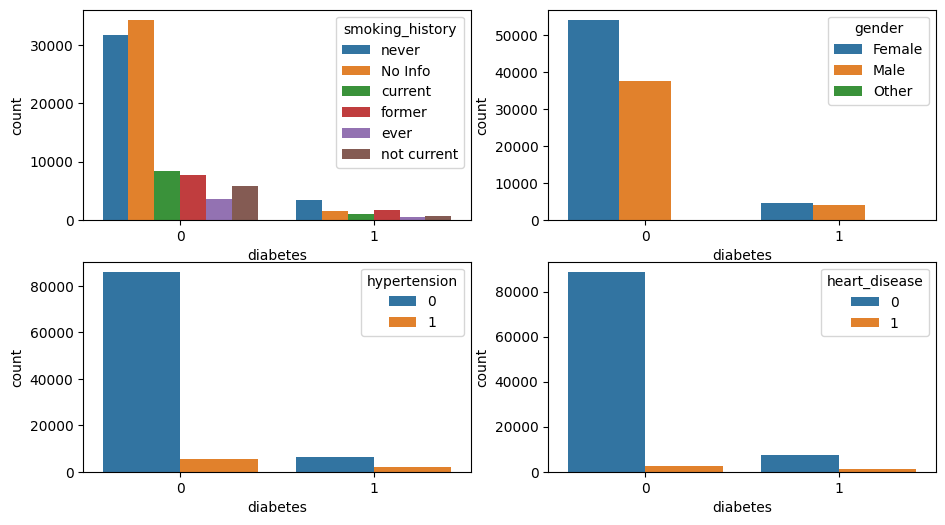

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(11, 6))
sns.countplot(x = bd["diabetes"], hue=bd["smoking_history"], ax = axs[0,0])
sns.countplot(x = bd["diabetes"], hue=bd["gender"], ax = axs[0,1])
sns.countplot(x = bd["diabetes"], hue=bd["hypertension"], ax = axs[1,0])
sns.countplot(x = bd["diabetes"], hue=bd["heart_disease"], ax = axs[1,1])

## Conversão dos dados não-numéricos

Para uma melhor análise dos dados, é importante que sejam convertidos os dados não-numéricos para valores numéricos.

In [ ]:
def treat_data(df):
  cols = df.columns.values

  for col in cols:
    digits = {}
    def turn_into_int(val):
      return digits[val]
    
    if(df[col].dtype != np.int64 and df[col].dtype != np.float64):
      to_convert = df[col].values.tolist()
      uniques = set(to_convert)

      cnt = 0
      for x in uniques:
        digits[x] = cnt
        cnt += 1

      df[col] = list(map(turn_into_int, df[col]))
  
  return df

treated_bd = treat_data(bd)

Checando os tipos dos dados:

In [ ]:
treated_bd.dtypes

gender                   int64
age                    float64
hypertension             int64
heart_disease            int64
smoking_history          int64
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

Checando os dados:

In [ ]:
treated_bd

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,80.0,0,1,1,25.19,6.6,140,0
1,1,54.0,0,0,3,27.32,6.6,80,0
2,0,28.0,0,0,1,27.32,5.7,158,0
3,1,36.0,0,0,4,23.45,5.0,155,0
4,0,76.0,1,1,4,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,1,80.0,0,0,3,27.32,6.2,90,0
99996,1,2.0,0,0,3,17.37,6.5,100,0
99997,0,66.0,0,0,5,27.83,5.7,155,0
99998,1,24.0,0,0,1,35.42,4.0,100,0


<Axes: xlabel='diabetes', ylabel='count'>

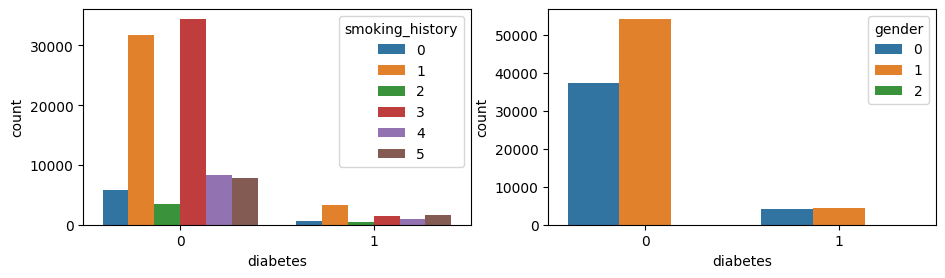

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(11, 2.8))
sns.countplot(x = bd["diabetes"], hue=bd["smoking_history"], ax = axs[0])
sns.countplot(x = bd["diabetes"], hue=bd["gender"], ax = axs[1])

# 3) Plotando Gráficos

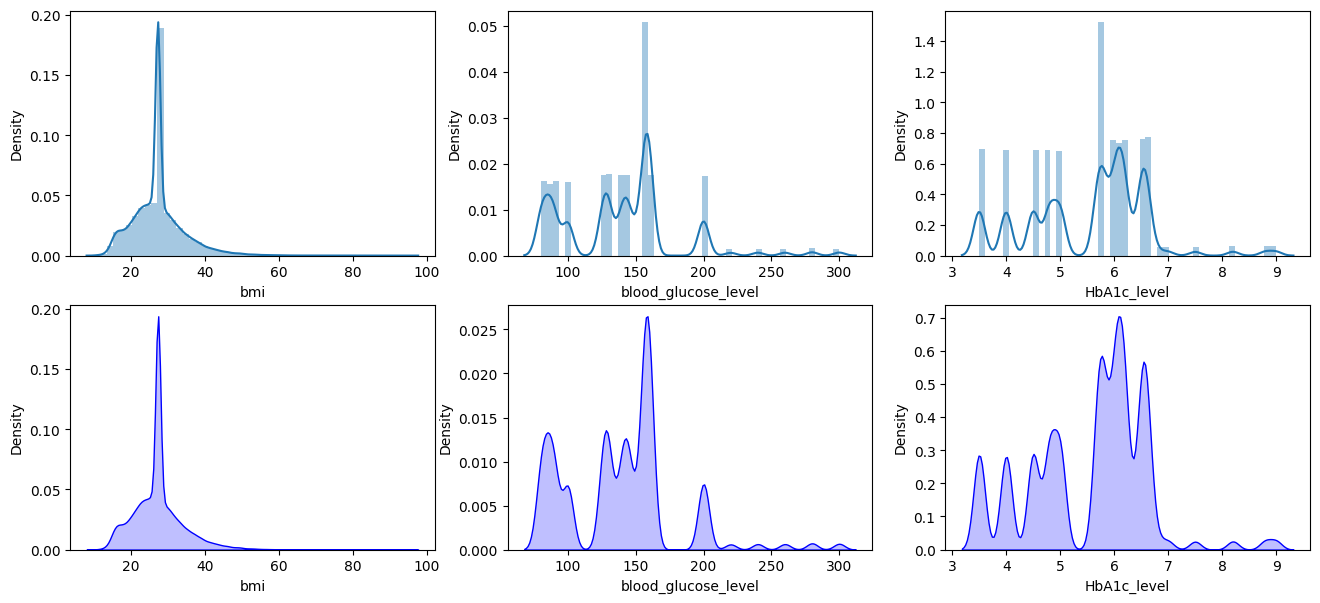

In [ ]:
import warnings
warnings.filterwarnings('ignore')

fig, axs = plt.subplots(2, 3, figsize=(16, 7))
sns.distplot( a=bd["bmi"], hist=True, kde=True, rug=False, ax=axs[0,0])
sns.distplot( a=bd["blood_glucose_level"], hist=True, kde=True, rug=False, ax=axs[0,1])
sns.distplot( a=bd["HbA1c_level"], hist=True, kde=True, rug=False, ax=axs[0,2])
sns.kdeplot(bd['bmi'], shade=True, color="b", ax=axs[1, 0])
sns.kdeplot(bd['blood_glucose_level'], shade=True, color="b", ax=axs[1, 1])
sns.kdeplot(bd['HbA1c_level'], shade=True, color="b", ax=axs[1, 2])
plt.show()

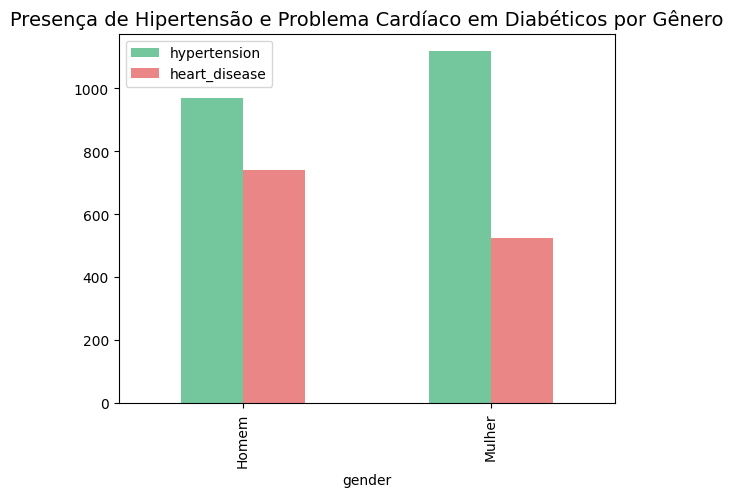

In [ ]:
bd_filtered = bd[(bd['diabetes'] == 1) & ((bd['hypertension'] == 1) | (bd['heart_disease'] == 1))]
#bd_filtered['gender'] = bd_filtered['gender'].replace({1: 'Mulher', 0: 'Homem'})
bd_grouped = bd_filtered.groupby('gender')[['hypertension', 'heart_disease']].sum()

ax = bd_grouped.plot(kind='bar', color=['#74c69d', '#ea8685'])
ax.set_title('Presença de Hipertensão e Problema Cardíaco em Diabéticos por Gênero', fontsize=14)

plt.show()

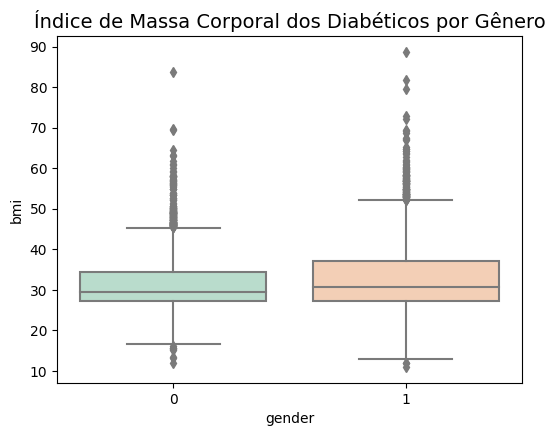

In [ ]:
bd_diabetes = bd[bd['diabetes'] == 1]
#bd_diabetes['gender'] = bd_diabetes['gender'].replace({1: 'Mulher', 0: 'Homem'})
plt.figure(figsize=(6,4.5))
sns.boxplot(x='gender', y='bmi', data=bd_diabetes, palette='Pastel2')
plt.title('Índice de Massa Corporal dos Diabéticos por Gênero', fontsize=14)
plt.show()

# 4) Identificando Outliers

Abaixo estão os valores numéricos da base de dados. É possível examinar várias informações importantes, como a quantidade de dados presentes em cada campo, a média, o desvio padrão, os valores mínimo e máximo e os quartis. Essas informações permitem compreender a distribuição dos dados em cada campo e auxiliam na identificação de possíveis outliers ou padrões interessantes na base de dados.

In [ ]:
bd.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.585880,41.885856,0.07485,0.039420,2.344550,27.320767,5.527507,138.058060,0.085000
std,0.492937,22.516840,0.26315,0.194593,1.435763,6.636783,1.070672,40.708136,0.278883
min,0.000000,0.080000,0.00000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,0.000000,24.000000,0.00000,0.000000,1.000000,23.630000,4.800000,100.000000,0.000000
50%,1.000000,43.000000,0.00000,0.000000,3.000000,27.320000,5.800000,140.000000,0.000000
75%,1.000000,60.000000,0.00000,0.000000,3.000000,29.580000,6.200000,159.000000,0.000000
max,2.000000,80.000000,1.00000,1.000000,5.000000,95.690000,9.000000,300.000000,1.000000


O boxplot é um gráfico que fornece uma visualização da distribuição dos dados e é frequentemente usado para identificar a presença de outliers. O gráfico consiste em:
- um retângulo que representa o intervalo interquartil (IQR) dos dados, ou seja, a diferença entre o terceiro quartil (Q3) e o primeiro quartil (Q1) da distribuição;
- dentro do retângulo, uma linha horizontal representa a mediana dos dados;
- fora do retângulo, linhas horizontais (chamadas de "bigodes") se estendem até os valores mínimo e máximo dos dados que não são considerados outliers.

Qualquer valor que esteja fora do intervalo dos bigodes é considerado um outlier e é representado por um ponto individual no gráfico. Esses pontos são frequentemente considerados incomuns ou anômalos em relação aos demais dados na distribuição.

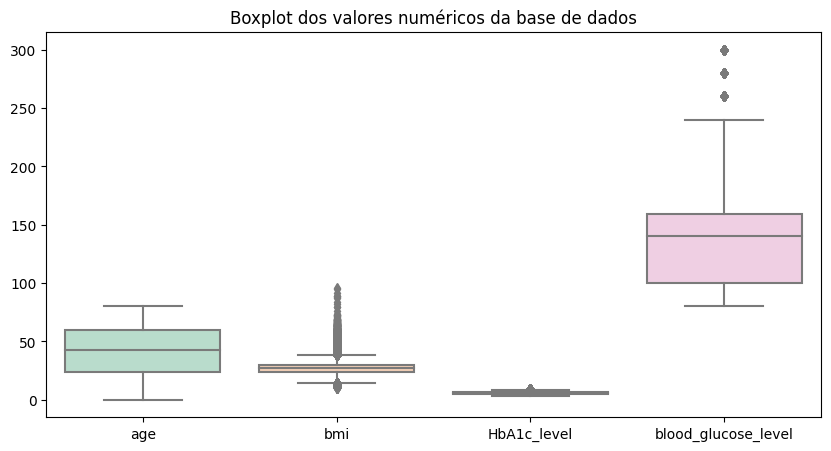

In [ ]:
bd_numeric = bd.select_dtypes(include=[float, int]).drop(['heart_disease', 'hypertension', 'diabetes', 'smoking_history', 'gender'], axis=1)

# Plot boxplot
plt.figure(figsize=(10,5))
sns.boxplot(data=bd_numeric, palette='Pastel2')
plt.title("Boxplot dos valores numéricos da base de dados")
plt.show()

Ao interpretar um boxplot, é fundamental considerar a posição e a quantidade de outliers, bem como a forma da distribuição dos dados. Quando a distribuição é muito assimétrica, pode indicar que a média não é uma medida adequada de tendência central, e que os outliers podem ter um impacto maior na análise. É importante prestar atenção a esses detalhes para tirar conclusões mais precisas a partir do boxplot. Vamos observar mais atentamente o boxplot do BMI, em comparação aos valores estatísticos:

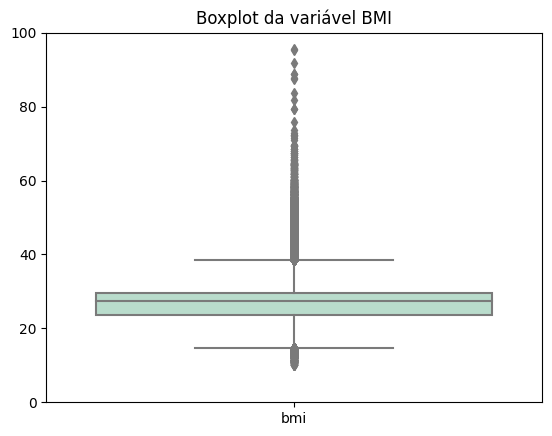

,bmi
count,100000.000000
mean,27.320767
std,6.636783
min,10.010000
25%,23.630000
50%,27.320000
75%,29.580000
max,95.690000


In [ ]:
bmi_numeric = bd_numeric[['bmi']]

sns.boxplot(data=bmi_numeric, palette='Pastel2')

plt.title("Boxplot da variável BMI")
plt.ylim(0, 100)
plt.show()

bmi_numeric.describe()

## Removendo outliers

Para realizar uma análise de dados com o classificador de Bayes, é necessário que os dados apresentem uma distribuição normal ou gaussiana. No entanto, a presença de outliers pode distorcer essa distribuição e, consequentemente, afetar os resultados da análise. Por isso, a remoção de outliers é uma etapa importante na análise de dados, mas deve ser realizada com cuidado para minimizar o impacto na análise final.

Para remover os outliers de forma mais precisa, utilizamos a regra do 1,5 IQR. Essa regra define limites superior e inferior baseados no intervalo interquartil (IQR) dos dados. Valores que estiverem acima ou abaixo desses limites são considerados outliers e removidos do conjunto de dados. Assim, garantimos uma análise mais precisa e confiável dos dados, considerando apenas os valores que realmente representam a distribuição dos mesmos.

In [ ]:
def remove_outliers_1_5_iqr(df, columns):
    for column in columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_limit = q1 - 1.5 * iqr
        upper_limit = q3 + 1.5 * iqr
        df = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]
    return df

cols = ["bmi", "HbA1c_level", "blood_glucose_level"]

bd_no_outliers = remove_outliers_1_5_iqr(bd, cols)

In [ ]:
bd_no_outliers.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,90387.000000,90387.000000,90387.000000,90387.000000,90387.000000,90387.000000,90387.000000,90387.000000,90387.000000
mean,0.581610,41.407823,0.065651,0.035625,2.344297,26.317686,5.456326,134.572571,0.049731
std,0.493679,22.558809,0.247672,0.185353,1.422464,4.878880,0.994868,35.197882,0.217389
min,0.000000,0.080000,0.000000,0.000000,0.000000,14.710000,3.500000,80.000000,0.000000
25%,0.000000,23.000000,0.000000,0.000000,1.000000,23.370000,4.800000,100.000000,0.000000
50%,1.000000,42.000000,0.000000,0.000000,3.000000,27.320000,5.800000,140.000000,0.000000
75%,1.000000,59.000000,0.000000,0.000000,3.000000,28.280000,6.200000,158.000000,0.000000
max,2.000000,80.000000,1.000000,1.000000,5.000000,38.500000,8.200000,240.000000,1.000000


Abaixo está o boxplot do novo conjunto de dados com os outliers removidos.

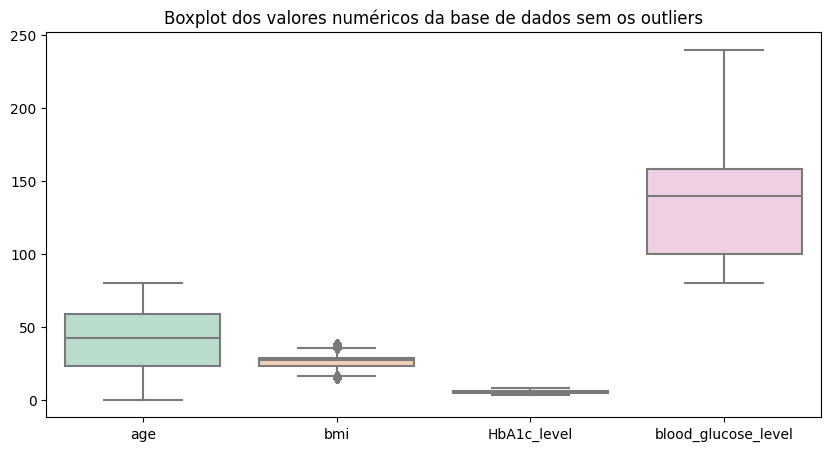

In [ ]:
bd_numeric = bd_no_outliers.select_dtypes(include=[float, int]).drop(['heart_disease', 'hypertension', 'diabetes', 'smoking_history', 'gender'], axis=1)

# Plot boxplot
plt.figure(figsize=(10,5))
sns.boxplot(data=bd_numeric, palette='Pastel2')
plt.title("Boxplot dos valores numéricos da base de dados sem os outliers")
plt.show()

# 5) Gaussian Bayes

Após o pré-processamento dos dados do conjunto de dados, é hora de aplicar o algoritmo Gaussian Bayes e avaliar sua precisão, tanto com os dados brutos quanto sem a presença de outliers. Abaixo é possível visualizar rapidamente o estado atual do conjunto de dados:

In [ ]:
bd.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,80.0,0,1,1,25.19,6.6,140,0
1,1,54.0,0,0,3,27.32,6.6,80,0
2,0,28.0,0,0,1,27.32,5.7,158,0
3,1,36.0,0,0,4,23.45,5.0,155,0
4,0,76.0,1,1,4,20.14,4.8,155,0


## Considerando os outliers

Primeiro, vamos selecionar todas as linhas (:) e as colunas de 0 a 7 (0:8) do conjunto de dados e armazenar o resultado na variável "X". Isso significa que estamos criando uma matriz "X" que contém os dados de entrada do modelo (também conhecidos como variáveis independentes ou features) para o algoritmo GaussianNB.

In [ ]:
X = bd.iloc[:,0:8].values
X

array([[  1.  ,  80.  ,   0.  , ...,  25.19,   6.6 , 140.  ],
       [  1.  ,  54.  ,   0.  , ...,  27.32,   6.6 ,  80.  ],
       [  0.  ,  28.  ,   0.  , ...,  27.32,   5.7 , 158.  ],
       ...,
       [  0.  ,  66.  ,   0.  , ...,  27.83,   5.7 , 155.  ],
       [  1.  ,  24.  ,   0.  , ...,  35.42,   4.  , 100.  ],
       [  1.  ,  57.  ,   0.  , ...,  22.43,   6.6 ,  90.  ]])

Depois, selecionamos todas as linhas (:) e a coluna 8 do conjunto de dados e armazenamos o resultado na variável "Y". Isso significa que estamos criando um vetor "Y" que contém os dados de saída do modelo (também conhecidos como variável dependente ou target) para o algoritmo GaussianNB.

In [ ]:
Y = bd.iloc[:, 8].values
Y

array([0, 0, 0, ..., 0, 0, 0])

Finalmente, o modelo GaussianNB é treinado utilizando os dados de entrada "X" e saída "Y" por meio do método `fit()`. Esse processo gera uma tabela de probabilidade para cada possível combinação de variáveis, utilizando uma distribuição normal para atribuir probabilidades a dados que não estão presentes no conjunto de dados. Essa abordagem é útil para estimar a probabilidade de uma determinada observação pertencer a uma classe específica, permitindo assim que o modelo faça previsões precisas mesmo em situações em que não possui todas as informações necessárias.

In [ ]:
naive_diabetes = GaussianNB()
naive_diabetes.fit(X,Y)

GaussianNB()

### Resultados interessantes

1. **Acurácia do modelo:** podemos usar o método `score()` do modelo para calcular a acurácia do modelo em prever a ocorrência de diabetes no conjunto de dados.

In [ ]:
acuracia = naive_diabetes.score(X,Y)
print("Acurácia do modelo:", acuracia)

Acurácia do modelo: 0.90351


2. **Probabilidades de classe:** podemos usar o atributo `class_prior_` do modelo para extrair as probabilidades de cada classe (diabético ou não diabético) no conjunto de dados.

In [ ]:
class_probabilities = naive_diabetes.class_prior_
print("Probabilidade de ser diabético:", class_probabilities[1])
print("Probabilidade de não ser diabético:", class_probabilities[0])

Probabilidade de ser diabético: 0.085
Probabilidade de não ser diabético: 0.915


3. **Distribuição de probabilidade:** podemos usar o atributo `theta_` do modelo para extrair a média de cada feature para cada classe, o que nos dá uma ideia de como as diferentes features se relacionam com a ocorrência de diabetes.

In [ ]:
feature_means = naive_diabetes.theta_
print("Média de cada feature para diabéticos:", feature_means[1])
print("Média de cada feature para não diabéticos:", feature_means[0])

Média de cada feature para diabéticos: [5.24823529e-01 6.09465882e+01 2.45647059e-01 1.49058824e-01
 2.39929412e+00 3.19883824e+01 6.93495294e+00 1.94094706e+02]
Média de cada feature para não diabéticos: [5.91551913e-01 4.01151869e+01 5.89836066e-02 2.92349727e-02
 2.33946448e+00 2.68871635e+01 5.39676066e+00 1.32852470e+02]


4. **Matriz de confusão**: uma tabela que mostra a frequência com que cada classe foi classificada corretamente ou incorretamente pelo modelo. Ela é composta por quatro valores: verdadeiro positivo (TP), falso positivo (FP), verdadeiro negativo (TN) e falso negativo (FN).

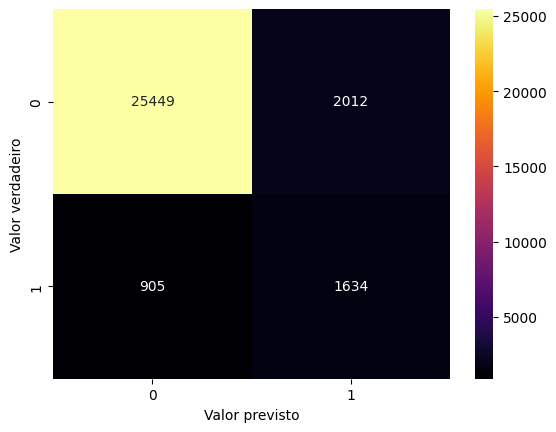

In [ ]:
# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# Fazer previsões com o modelo treinado
y_pred = naive_diabetes.predict(X_test)

# Calcular matriz de confusão
confusion = confusion_matrix(y_test, y_pred)

# Plotar matriz de confusão com seaborn
sns.heatmap(confusion, annot=True, cmap='inferno', fmt='g')
plt.xlabel('Valor previsto')
plt.ylabel('Valor verdadeiro')
plt.show()

### Previsões

Podemos utilizar o modelo treinado com os dados disponíveis para fazer previsões sobre um novo indivíduo com características conhecidas. Por exemplo, suponha que temos um novo indivíduo com as seguintes características:

- mulher (0),
- 55 anos,
- sem hipertensão (0),
- sem doença no coração (0),
- sem histórico de tabagismo (0),
- IMC = 25,
- nível de HbA1c = 7,
- nível de glicose no sangue = 150.

Fazendo a previsão para este indivíduo usando o método `predict()` do modelo treinado, podemos obter uma estimativa da probabilidade dele ser diabético ou não. Caso a probabilidade seja alta, podemos afirmar que ele provavelmente é diabético. Caso contrário, podemos afirmar que ele provavelmente não é diabético.

In [ ]:
# Dados dos novos indivíduos
novos_individuos = [
    [0, 55, 0, 0, 0, 25, 7, 150],
    [2, 55, 0, 0, 0, 25, 7, 150], # mulher -> homem
    [0, 25, 0, 0, 0, 25, 7, 150], # 55 anos -> 25
    [0, 55, 1, 0, 0, 25, 7, 150], # sem hipertensão -> com
    [0, 55, 0, 1, 0, 25, 7, 150], # sem doença no coração -> com
    [0, 55, 0, 0, 2, 25, 7, 150], # sem histórico de tabagismo -> com
    [0, 55, 0, 0, 0, 38, 7, 150], # IMC 25 -> 38
    [0, 55, 0, 0, 0, 25, 5, 150], # nível de HbA1c 7 -> 5
    [0, 55, 0, 0, 0, 25, 7, 80]   # nível de glicose no sangue 150 -> 80
]

# Predição para cada novo indivíduo
for i, new_individual in enumerate(novos_individuos):
    prediction = naive_diabetes.predict([new_individual])
    
    # Informações sobre o novo indivíduo e a predição do modelo
    print(f"Novo indivíduo {i+1}: {new_individual}")
    print(f"Probabilidade de ser diabético: {naive_diabetes.predict_proba([new_individual])[0][1]:.2%}")

    if prediction[0] == 1:
        print("O novo indivíduo provavelmente é diabético.")
    else:
        print("O novo indivíduo provavelmente não é diabético.")
    print("-" * 50)


Novo indivíduo 1: [0, 55, 0, 0, 0, 25, 7, 150]
Probabilidade de ser diabético: 4.68%
O novo indivíduo provavelmente não é diabético.
--------------------------------------------------
Novo indivíduo 2: [2, 55, 0, 0, 0, 25, 7, 150]
Probabilidade de ser diabético: 3.08%
O novo indivíduo provavelmente não é diabético.
--------------------------------------------------
Novo indivíduo 3: [0, 25, 0, 0, 0, 25, 7, 150]
Probabilidade de ser diabético: 0.25%
O novo indivíduo provavelmente não é diabético.
--------------------------------------------------
Novo indivíduo 4: [0, 55, 1, 0, 0, 25, 7, 150]
Probabilidade de ser diabético: 97.23%
O novo indivíduo provavelmente é diabético.
--------------------------------------------------
Novo indivíduo 5: [0, 55, 0, 1, 0, 25, 7, 150]
Probabilidade de ser diabético: 100.00%
O novo indivíduo provavelmente é diabético.
--------------------------------------------------
Novo indivíduo 6: [0, 55, 0, 0, 2, 25, 7, 150]
Probabilidade de ser diabético: 3.28%


## Sem considerar os outliers

Agora, realizaremos uma análise semelhante, porém, dessa vez, excluindo os valores discrepantes do conjunto de dados.

In [ ]:
X_no_outliers = bd_no_outliers.iloc[:,0:8].values
Y_no_outliers = bd_no_outliers.iloc[:, 8].values
naive_diabetes_no_outliers = GaussianNB()
naive_diabetes_no_outliers.fit(X_no_outliers,Y_no_outliers)

GaussianNB()

### Resultados interessantes

1. **Acurácia do modelo**

In [ ]:
acuracia = naive_diabetes_no_outliers.score(X_no_outliers,Y_no_outliers)
print("Acurácia do modelo:", acuracia)

Acurácia do modelo: 0.9082500802106498


2. **Probabilidades de classe**

In [ ]:
class_probabilities = naive_diabetes_no_outliers.class_prior_
print("Probabilidade de ser diabético:", class_probabilities[1])
print("Probabilidade de não ser diabético:", class_probabilities[0])

Probabilidade de ser diabético: 0.04973060285218007
Probabilidade de não ser diabético: 0.9502693971478199


3. **Distribuição de probabilidade**

In [ ]:
feature_means = naive_diabetes_no_outliers.theta_
print("Média de cada feature para diabéticos:", feature_means[1])
print("Média de cada feature para não diabéticos:", feature_means[0])

Média de cada feature para diabéticos: [5.03448276e-01 6.19174638e+01 2.40266963e-01 1.53726363e-01
 2.43114572e+00 2.93079889e+01 6.57915462e+00 1.67262291e+02]
Média de cada feature para não diabéticos: [5.85700647e-01 4.03344889e+01 5.65128301e-02 2.94439529e-02
 2.33975225e+00 2.61611935e+01 5.39756438e+00 1.32861815e+02]


4. **Matriz de confusão**

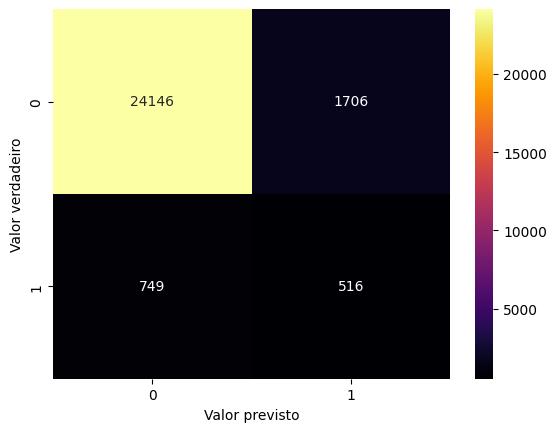

In [ ]:
# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_no_outliers, Y_no_outliers, test_size=0.3, random_state=0)

# Fazer previsões com o modelo treinado
y_pred = naive_diabetes_no_outliers.predict(X_test)

# Calcular matriz de confusão
confusion = confusion_matrix(y_test, y_pred)

# Plotar matriz de confusão com seaborn
sns.heatmap(confusion, annot=True, cmap='inferno', fmt='g')
plt.xlabel('Valor previsto')
plt.ylabel('Valor verdadeiro')
plt.show()

# 6) Técnica SMOTE

Smote é uma técnica que aumenta a quantidade de dados da classe minoritária, incluindo dados sintéticos, a fim de diminuir o viés causado pela baixa disponibilidade de dados da classe minoritária.
Aplicaremos a técnica smote à nossa base de dados, visando diminuir o viés causado pela baixa disponibilidade de pessoas com diabetes no nosso banco de dados.

## Aplicando SMOTE aos dados com outliers

In [ ]:
smote = SMOTE()
#acrescentando dados sintéticos aos dados com outliers
X_smote, Y_smote = smote.fit_resample(X, Y)



In [ ]:
naive_diabetes_smote = GaussianNB()
naive_diabetes_smote.fit(X_smote,Y_smote)

GaussianNB()

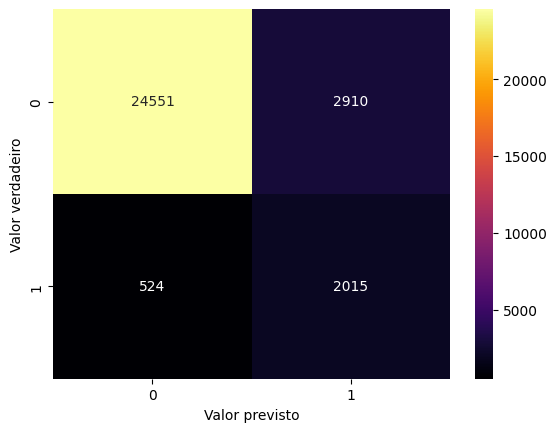

In [ ]:
# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# Fazer previsões com o modelo treinado
y_pred = naive_diabetes_smote.predict(X_test)

# Calcular matriz de confusão
confusion = confusion_matrix(y_test, y_pred)

# Plotar matriz de confusão com seaborn
sns.heatmap(confusion, annot=True, cmap='inferno', fmt='g')
plt.xlabel('Valor previsto')
plt.ylabel('Valor verdadeiro')
plt.show()

In [ ]:
acuracia = naive_diabetes_smote.score(X,Y)
print("Acurácia do modelo:", acuracia)

Acurácia do modelo: 0.88653


Aplicando SMOTE aos dados com outliers, percebemos que a quantidade de falsos negativos diminuiu significativamente, os quais passam a representar apenas 20% das previsões quando a pessoa realmente possui a doença.

Por outro lado,a acurácia diminuiu. Isso se deve ao aumento na quantidade de falsos positivos. Por certo lado isso e esperado, dado que não melhoramos a qualidade dos dados com o SMOTE, somente aumentamos a quantidade de dados e não a qualidade.

## Aplicando SMOTE aos dados sem outliers

In [ ]:
X_smote_no_outliers, Y_smote_no_outliers = smote.fit_resample(X_no_outliers, Y_no_outliers)

In [ ]:
naive_diabetes_smote_no_outliers = GaussianNB()
#acrescentando dados sintéticos aos dados sem outiliers
naive_diabetes_smote_no_outliers.fit(X_smote_no_outliers,Y_smote_no_outliers)

GaussianNB()

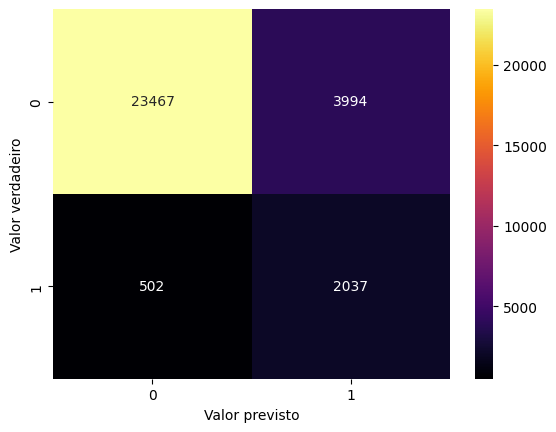

In [ ]:
# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# Fazer previsões com o modelo treinado
y_pred = naive_diabetes_smote_no_outliers.predict(X_test)

# Calcular matriz de confusão
confusion = confusion_matrix(y_test, y_pred)

# Plotar matriz de confusão com seaborn
sns.heatmap(confusion, annot=True, cmap='inferno', fmt='g')
plt.xlabel('Valor previsto')
plt.ylabel('Valor verdadeiro')
plt.show()

In [ ]:
acuracia = naive_diabetes_smote_no_outliers.score(X,Y)
print("Acurácia do modelo:", acuracia)

Acurácia do modelo: 0.85243
